In [ ]:
import torch
from torch import nn, optim
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils import data
from torch.nn.functional import interpolate
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


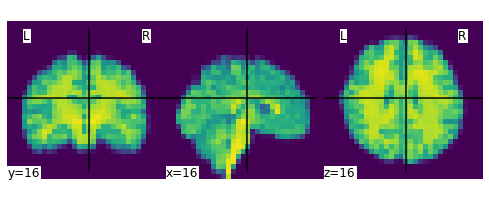

In [ ]:

from IPython.display import clear_output

!pip install nilearn
import nibabel as nib
from nilearn import plotting

labels = np.load("MyDrive/labels.npy")
tensors = np.load("MyDrive/tensors.npy")


def plot_scan(scan, *args, **kwargs):
  affine = np.diag([1, 1, 1, 1])
  if type(scan) != np.ndarray:
    scan = scan.detach().cpu().numpy()
  t = nib.Nifti1Image(scan, affine)
  plotting.plot_img(t, [s/2 for s in scan.shape], *args, **kwargs)
tensors = interpolate(torch.Tensor(tensors[:, None]), mode='trilinear', size=(32, 32, 32))
plot_scan(tensors[0, 0])

## Model

In [ ]:
class EqualizingWrapper(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        nn.init.normal_(layer.weight)
        n = np.prod(layer.weight.shape[1:])
        self.c = np.sqrt(2 / n)

    def forward(self, x):
        self.layer.weight.data = self.layer.weight.data * self.c
        x = self.layer(x)
        self.layer.weight.data = self.layer.weight.data / self.c
        return x


class AdaIN3D(nn.Module):
    def __init__(self, latent_size, out_channels):
        super().__init__()
        self.layer = EqualizingWrapper(nn.Linear(latent_size, out_channels * 2))
        self.layer.layer.bias.data.fill_(1)

    def forward(self, x, latent_vector):
        # Instance Normalization
        mean = x.mean(dim=-1).mean(dim=-1).mean(dim=-1)[..., None, None, None]
        std = x.std(dim=-1).std(dim=-1).std(dim=-1)[..., None, None, None]
        x = (x - mean) / torch.sqrt(std ** 2 + 1e-8)
        # Adaptation with style
        y = self.layer(latent_vector)
        shape = [-1, 2, x.shape[1]] + (x.dim() - 2) * [1]
        y = y.view(shape)

        x = x * y[:, 0] + y[:, 1]
        return x


class MappingNetwork(nn.Module):
    def __init__(self, latent_size, depth=8):
        super().__init__()
        blocks = [
            [EqualizingWrapper(nn.Linear(latent_size, latent_size)), nn.LeakyReLU(0.2)]
            for d in range(depth)
        ]
        # flatten the list
        layers = [l for block in blocks for l in block]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class SequentialWithAdaIN(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.layers = nn.ModuleList(list(args))
        self.start_with_adain = type(self.layers[0]) == AdaIN3D

    def forward(self, x, w):
        start_idx = 0
        if self.start_with_adain:
            x = self.layers[0](x, w)
            start_idx = 1
        for i in range(start_idx, len(self.layers), 2):
            x = self.layers[i](x)
            x = self.layers[i + 1](x, w)
        return x


class NoiseAdder3D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))

    def forward(self, x, noise=None):
        if noise is None:
            noise = torch.randn(
                x.size(0),
                1,
                x.size(2),
                x.size(3),
                x.size(4),
                device=x.device,
                dtype=x.dtype,
            )
        return x + self.weight.view(1, -1, 1, 1, 1) * noise.to(x.device)



class MiniBatchStdDev(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        std = x.std(dim=0).mean()
        x = torch.cat([x, torch.ones_like(x[:, 0:1]) * std], dim=1)
        return x
        
def ConvBlock3D(in_channels, out_channels, kernel_size=3, padding=0, relu_leak=0.2):
    return nn.Sequential(
        EqualizingWrapper(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding)
        ),
        NoiseAdder3D(out_channels),
        nn.LeakyReLU(relu_leak),
    )


def GeneratorBlock3D(in_channels, out_channels, latent_size):
    return SequentialWithAdaIN(
        ConvBlock3D(in_channels, out_channels, padding=1),
        AdaIN3D(latent_size, out_channels),
        ConvBlock3D(out_channels, out_channels, padding=1),
        AdaIN3D(latent_size, out_channels),
    )


In [ ]:
class StyleGenerator(nn.Module):
    def __init__(
        self, hidden_channels, latent_size, max_resolution=32, start_resolution=4
    ):
        super().__init__()
        self.alpha = 1.0
        self.cur_last = int(np.log2(start_resolution)) - 2
        self.toRGB = EqualizingWrapper(nn.Conv3d(hidden_channels, 1, kernel_size=1))
        self.const_input = nn.Parameter(torch.ones(1, hidden_channels, 4, 4, 4))
        self.mapping_net = MappingNetwork(latent_size)
        self.layers = nn.ModuleList(
            [
                SequentialWithAdaIN(
                    AdaIN3D(latent_size, hidden_channels),
                    ConvBlock3D(hidden_channels, hidden_channels, 3, padding=1),
                    AdaIN3D(latent_size, hidden_channels),
                )
            ]
            + [
                GeneratorBlock3D(hidden_channels, hidden_channels, latent_size)
                for size in range(int(np.log2(max_resolution) - 1))
            ]
        )

    def forward(self, z):
        z = torch.nn.functional.normalize(z)
        w = self.mapping_net(z)

        out = self.layers[0](self.const_input, w)
        for i in range(self.cur_last):
            up = interpolate(
                out,
                scale_factor=2,
                mode="trilinear",
                align_corners=False,
                recompute_scale_factor=False,
            )
            out = self.layers[i + 1](up, w)
        if self.cur_last > 0:
            return self.alpha * self.toRGB(out) + (1 - self.alpha) * self.toRGB(up)
        return self.toRGB(out)

    def increase_resolution(self):
        self.cur_last += 1
        self.alpha = 0

    def increase_alpha(self):
        self.alpha = min(1, self.alpha + 0.1)



class ProgressiveDiscriminator(nn.Module):
    def __init__(self, hidden_channels, max_resolution=32, start_resolution=4):
        super().__init__()
        self.alpha = 1.0
        self.cur_last = int(np.log2(start_resolution)) - 2
        self.fromRGB = EqualizingWrapper(nn.Conv3d(1, hidden_channels, kernel_size=1))
        self.layers = nn.ModuleList(
            [
                nn.Sequential(
                    MiniBatchStdDev(),
                    ConvBlock3D(hidden_channels + 1, hidden_channels, 3, padding=1),
                    ConvBlock3D(hidden_channels, hidden_channels, 4),
                    nn.Flatten(),
                    EqualizingWrapper(nn.Linear(hidden_channels, 1)),
                )
            ]
            + [
                nn.Sequential(
                    ConvBlock3D(hidden_channels, hidden_channels, 3, padding=1),
                    ConvBlock3D(hidden_channels, hidden_channels, 3, padding=1),
                )
                for size in range(int(np.log2(max_resolution) - 1))
            ]
        )

    def forward(self, img):
        out = self.fromRGB(img)
        out = self.layers[self.cur_last](out)
        last_applied = self.cur_last

        if self.cur_last > 0:
            down = interpolate(
                img,
                scale_factor=0.5,
                mode="trilinear",
                align_corners=False,
                recompute_scale_factor=False,
            )
            down = self.fromRGB(down)
            out = interpolate(
                out,
                scale_factor=0.5,
                mode="trilinear",
                align_corners=False,
                recompute_scale_factor=False,
            )
            out = self.alpha * out + (1 - self.alpha) * down
            out = self.layers[self.cur_last - 1](out)
            last_applied = self.cur_last - 1

        for i in range(last_applied - 1, -1, -1):
            out = interpolate(
                out,
                scale_factor=0.5,
                mode="trilinear",
                align_corners=False,
                recompute_scale_factor=False,
            )
            out = self.layers[i](out)
        return out

    def increase_resolution(self):
        self.cur_last += 1
        self.alpha = 0

    def increase_alpha(self):
        self.alpha = min(1, self.alpha + 0.1)


### Some tests

In [ ]:
# Tests
g = StyleGenerator(128, 32)
d = ProgressiveDiscriminator(128)

i1 = g(torch.randn(64, 32))
assert i1.shape == (64, 1, 4, 4, 4)

g.increase_resolution()

i2 = g(torch.randn(64, 32))
assert i2.shape == (64, 1, 8, 8, 8)

g.increase_resolution()

i3 = g(torch.randn(64, 32))
assert i3.shape == (64, 1, 16, 16, 16)


g = StyleGenerator(128, 32, start_resolution=8)
i2 = g(torch.randn(64, 32))
assert i2.shape == (64, 1, 8, 8, 8)

assert d(i1).shape == (64, 1)
d.increase_resolution()
assert d(i2).shape == (64, 1)
d.increase_resolution()
assert d(i3).shape == (64, 1)
print(d(i3)[0])


tensor([27.9647], grad_fn=<SelectBackward>)


In [ ]:

# CUDA tests
g = StyleGenerator(128, 32).cuda()
d = ProgressiveDiscriminator(128).cuda()

i1 = g(torch.randn(64, 32).cuda())
assert i1.shape == (64, 1, 4, 4, 4)

g.increase_resolution()

i2 = g(torch.randn(64, 32).cuda())
assert i2.shape == (64, 1, 8, 8, 8)

g.increase_resolution()

i3 = g(torch.randn(64, 32).cuda())
assert i3.shape == (64, 1, 16, 16, 16)

assert d(i1).shape == (64, 1)
d.increase_resolution()
assert d(i2).shape == (64, 1)
d.increase_resolution()
assert d(i3).shape == (64, 1)

## Losses

In [ ]:
from torch import autograd

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels.squeeze().cuda())
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels.squeeze().cuda())
    return loss

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.cuda.FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = autograd.Variable(torch.cuda.FloatTensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## Training

In [ ]:
# @title Initialization { display-mode: "form" }
z_size = 128  # @param {type:"integer"}
hidden_size = 256  # @param {type:"integer"}
start_resolution = 8  # @param {type:"integer"}
batch_size =   16# @param {type:"integer"}
max_resolution = 32

G = StyleGenerator(hidden_size, z_size, start_resolution=start_resolution).cuda()
D = ProgressiveDiscriminator(hidden_size, start_resolution=start_resolution).cuda()

loss_func = "WGAN-GP"  # @param ["WGAN-GP", "GAN"]

# Optimizers
betas = [0, 0.99]
alpha = 0.002  # @param {type:"number"}

d_optimizer = optim.Adam(D.parameters(), betas=betas, lr=alpha)
g_optimizer = optim.Adam(G.parameters(), betas=betas, lr=alpha)

def get_resizing_func(size):
  return lambda img: interpolate(
              img,
              size=(size, size, size),
              mode="trilinear",
              align_corners=False,
              recompute_scale_factor=False,
          )
resize_to = {
    size: get_resizing_func(size)
    for size in range(4, max_resolution + 1, 4)
}

ds = data.TensorDataset(tensors, torch.Tensor(labels))
train_loader = data.DataLoader(ds, batch_size=batch_size)

#ds = SVHN(".", download=True, transform=transforms.ToTensor())
#train_loader = data.DataLoader(ds, batch_size, shuffle=True)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Epoch [   18/  100] | d_loss: -109.1101 | g_loss: 285.8906
Epoch [   18/  100] | d_loss: -50.1450 | g_loss: 125.6915
Epoch [   18/  100] | d_loss: -63.2092 | g_loss: 89.5463
Epoch [   18/  100] | d_loss: -51.7263 | g_loss: 139.5285
Epoch [   18/  100] | d_loss: -105.9230 | g_loss: 216.0133
Epoch [   18/  100] | d_loss: -39.4730 | g_loss: 68.0731
Epoch [   18/  100] | d_loss: -53.5538 | g_loss: 163.3765
Epoch [   18/  100] | d_loss: -46.9383 | g_loss: 85.9238
Epoch [   18/  100] | d_loss: -51.0532 | g_loss: 113.0407



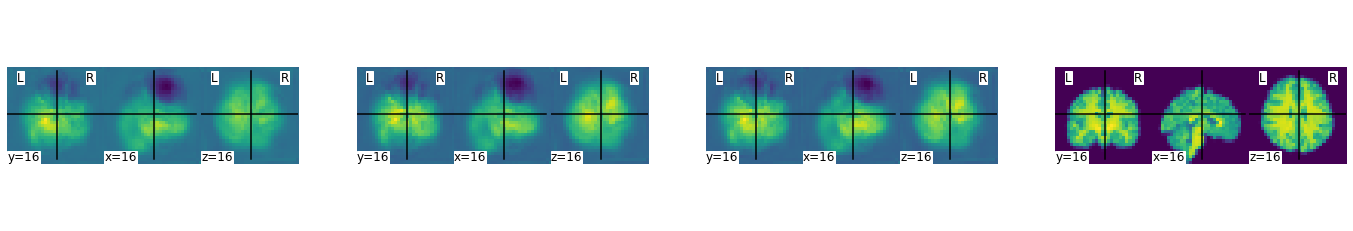

Epoch [   19/  100] | d_loss: -51.6666 | g_loss: 197.6385
Epoch [   19/  100] | d_loss: -38.5779 | g_loss: 89.8643
Epoch [   19/  100] | d_loss: -73.3531 | g_loss: 110.8677
Epoch [   19/  100] | d_loss: -9.3893 | g_loss: 145.0412
Epoch [   19/  100] | d_loss: -36.3353 | g_loss: 44.5819
Epoch [   19/  100] | d_loss: -38.6638 | g_loss: 119.3667
Epoch [   19/  100] | d_loss: -43.2564 | g_loss: 122.9464
Epoch [   19/  100] | d_loss: -58.7958 | g_loss: 134.7343
Epoch [   19/  100] | d_loss: -90.2803 | g_loss: 167.9562



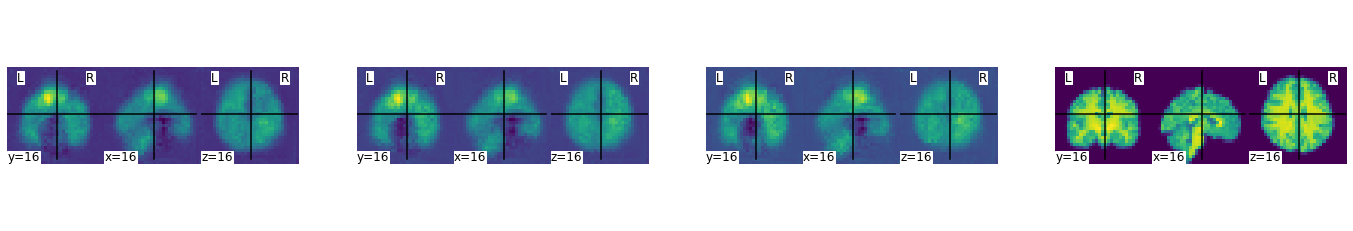

Epoch [   20/  100] | d_loss: -49.2100 | g_loss: 75.5133
Epoch [   20/  100] | d_loss: -26.2700 | g_loss: 54.7475
Epoch [   20/  100] | d_loss: -46.5372 | g_loss: 93.5578
Epoch [   20/  100] | d_loss: -41.7157 | g_loss: 84.4555
Epoch [   20/  100] | d_loss: -36.2705 | g_loss: 73.6454
Epoch [   20/  100] | d_loss: -35.3576 | g_loss: 90.8353
Epoch [   20/  100] | d_loss: -21.0945 | g_loss: 71.8805
Epoch [   20/  100] | d_loss: -10.0054 | g_loss: 18.8452
Epoch [   20/  100] | d_loss: -27.2083 | g_loss: 37.9084



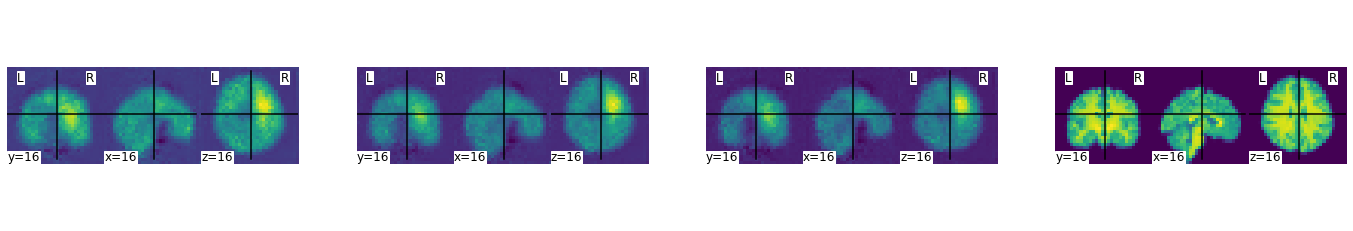

Epoch [   21/  100] | d_loss: -48.9503 | g_loss: 156.7820
Epoch [   21/  100] | d_loss: -15.6320 | g_loss: 44.1087
Epoch [   21/  100] | d_loss: -22.4988 | g_loss: 25.3456
Epoch [   21/  100] | d_loss: -18.9729 | g_loss: 19.4073
Epoch [   21/  100] | d_loss: -15.0944 | g_loss: 253.9120
Epoch [   21/  100] | d_loss: -40.5396 | g_loss: 77.5400
Epoch [   21/  100] | d_loss: -23.1977 | g_loss: 43.4306
Epoch [   21/  100] | d_loss: -9.9201 | g_loss: 14.3562
Epoch [   21/  100] | d_loss: -10.6188 | g_loss: 16.8113



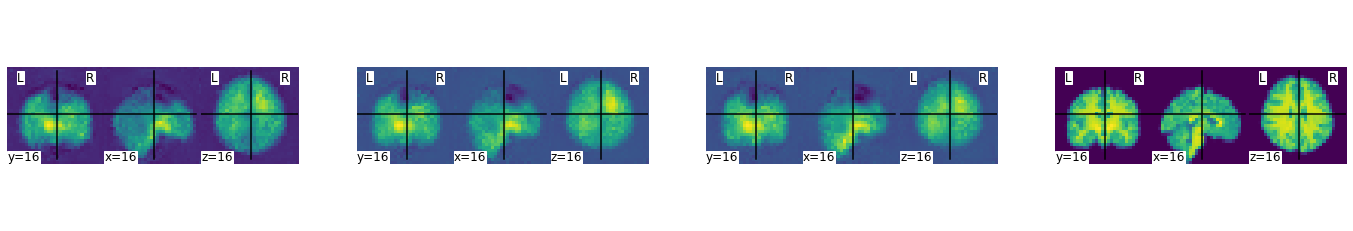

Epoch [   22/  100] | d_loss: -43.8116 | g_loss: 91.0290
Epoch [   22/  100] | d_loss: -23.6158 | g_loss: 26.5864
Epoch [   22/  100] | d_loss: -15.8802 | g_loss: 11.4670
Epoch [   22/  100] | d_loss: -28.6234 | g_loss: 68.2184
Epoch [   22/  100] | d_loss: -28.7495 | g_loss: 97.9222
Epoch [   22/  100] | d_loss: -7.6277 | g_loss: 7.6918
Epoch [   22/  100] | d_loss: -33.7634 | g_loss: 71.3838
Epoch [   22/  100] | d_loss: -9.6896 | g_loss: 13.2677
Epoch [   22/  100] | d_loss: -9.4029 | g_loss: 26.8478



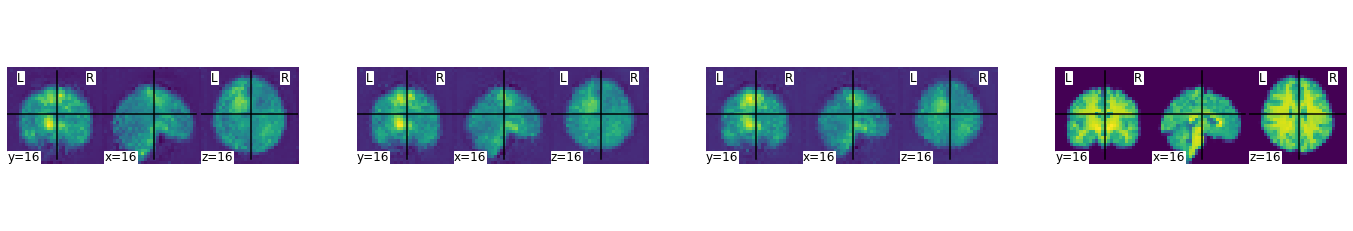

Epoch [   23/  100] | d_loss: -13.6510 | g_loss: 7.7439
Epoch [   23/  100] | d_loss: -13.1754 | g_loss: 10.2079
Epoch [   23/  100] | d_loss: -23.7066 | g_loss: 41.6564
Epoch [   23/  100] | d_loss: -11.3990 | g_loss: 12.4470
Epoch [   23/  100] | d_loss: -28.7441 | g_loss: 54.1487
Epoch [   23/  100] | d_loss: -10.4905 | g_loss: 17.7381
Epoch [   23/  100] | d_loss: -18.4585 | g_loss: 39.4302
Epoch [   23/  100] | d_loss: -32.5351 | g_loss: 34.9032
Epoch [   23/  100] | d_loss: -24.3042 | g_loss: 43.1899



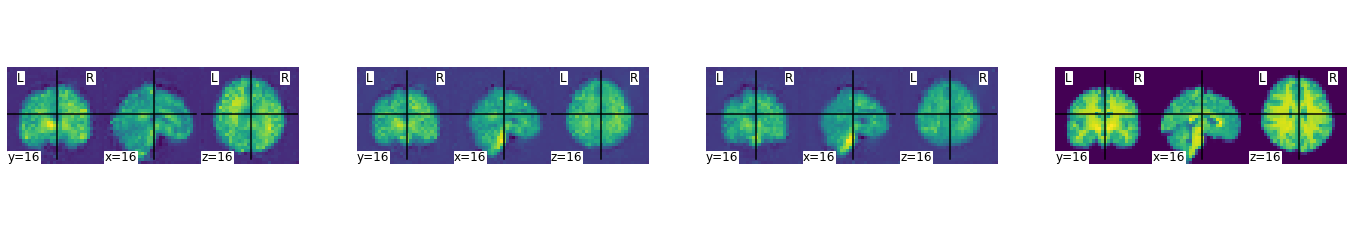

Epoch [   24/  100] | d_loss: -18.0684 | g_loss: 24.0561
Epoch [   24/  100] | d_loss: -25.6968 | g_loss: 37.5166
Epoch [   24/  100] | d_loss: -7.4077 | g_loss: -15.8457
Epoch [   24/  100] | d_loss: -17.9989 | g_loss: 37.6914
Epoch [   24/  100] | d_loss: -8.8607 | g_loss: 27.7994
Epoch [   24/  100] | d_loss: -34.0497 | g_loss: 32.5850
Epoch [   24/  100] | d_loss: -22.7663 | g_loss: 51.3031
Epoch [   24/  100] | d_loss: -21.8686 | g_loss: 35.6187
Epoch [   24/  100] | d_loss: -12.5444 | g_loss: 31.8916



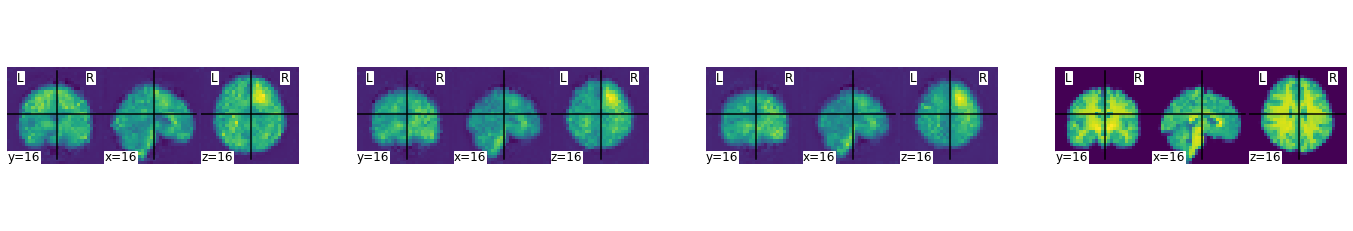

Epoch [   25/  100] | d_loss: -16.6969 | g_loss: 42.7192
Epoch [   25/  100] | d_loss: -24.0140 | g_loss: 51.0853
Epoch [   25/  100] | d_loss: -6.7010 | g_loss: 6.1737
Epoch [   25/  100] | d_loss: -20.9386 | g_loss: 36.7243
Epoch [   25/  100] | d_loss: -17.9911 | g_loss: 43.1235
Epoch [   25/  100] | d_loss: -6.2085 | g_loss: -12.4326
Epoch [   25/  100] | d_loss: -17.6978 | g_loss: 33.4727
Epoch [   25/  100] | d_loss: -10.9373 | g_loss: 25.1596
Epoch [   25/  100] | d_loss: -7.4361 | g_loss: 11.1357



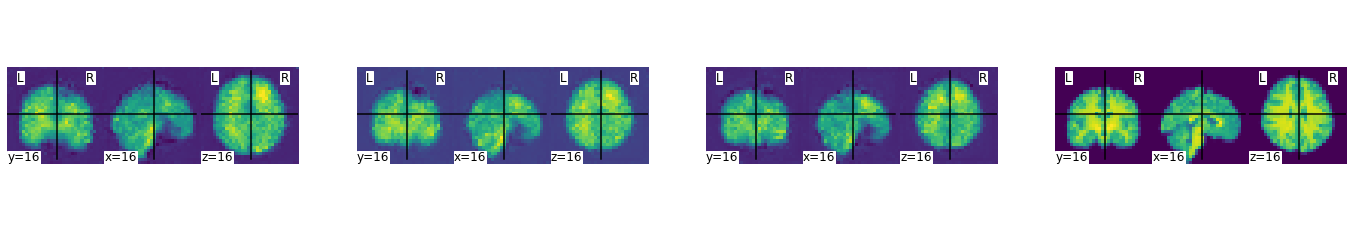

Epoch [   26/  100] | d_loss: -14.1889 | g_loss: 39.5617
Epoch [   26/  100] | d_loss: -14.3123 | g_loss: 30.6158
Epoch [   26/  100] | d_loss: -22.0812 | g_loss: 4.7346
Epoch [   26/  100] | d_loss: -20.1873 | g_loss: 41.0050
Epoch [   26/  100] | d_loss: -18.4767 | g_loss: 40.0313
Epoch [   26/  100] | d_loss: -15.4623 | g_loss: 25.8253
Epoch [   26/  100] | d_loss: -18.1757 | g_loss: 28.6315
Epoch [   26/  100] | d_loss: -16.2739 | g_loss: 16.2232
Epoch [   26/  100] | d_loss: -7.3226 | g_loss: -1.2420



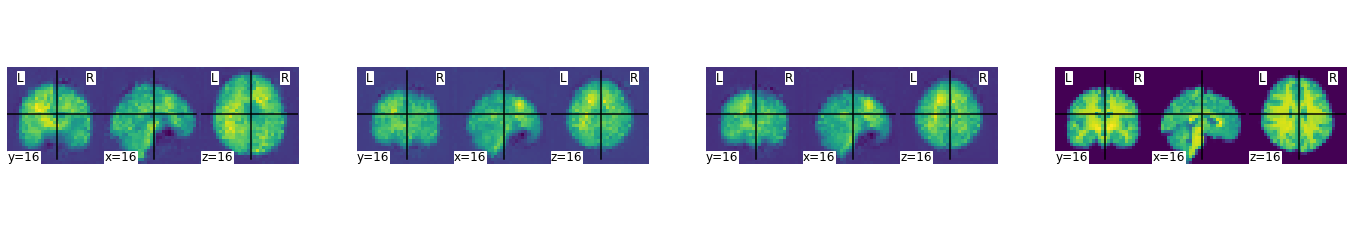

Epoch [   27/  100] | d_loss: -19.9328 | g_loss: 54.8017
Epoch [   27/  100] | d_loss: -9.3710 | g_loss: 3.4263
Epoch [   27/  100] | d_loss: -14.0906 | g_loss: 18.7046


In [ ]:


# training hyperparams
num_epochs = 100
start_epoch = 0
# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 31
increase_resolution_every = 8
increase_alpha_every = len(ds) // batch_size * 3 // 10

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=4
fixed_z = torch.randn(sample_size, z_size, dtype=torch.float32).cuda()

#cur_resolution = start_resolution
lambda_gp = 10

data_max, data_min = tensors.max(), tensors.min()
data_range = data_max - data_min

# train the network
D.train()
G.train()

for epoch in range(start_epoch, num_epochs):
    
    for batch_i, (real_images, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
                
        bs = real_images.size(0)
        if bs < 3:
          continue
        if np.prod(real_images.shape) == 0:
          continue

        real_images = real_images.cuda()
        real_images = (real_images - data_min) / data_range * 2 - 1
        if cur_resolution > 4:
          down_up = interpolate(resize_to[cur_resolution // 2](real_images), mode='trilinear', scale_factor=2, )
          down = resize_to[cur_resolution](real_images)
          real_images = resize_to[cur_resolution](real_images) * D.alpha + \
               down_up * (1 - D.alpha)
        else:
          real_images = resize_to[cur_resolution](real_images)
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        D_real = D(real_images)
        
        # 2. Train with fake images
        
        with torch.no_grad():
            z = torch.randn(bs, z_size, dtype=torch.float32).cuda()
            fake_images = G(z)
              
        D_fake = D(fake_images)
        
        # add up loss and perform backprop
        if loss_func == "WGAN-GP":
          gradient_penalty = compute_gradient_penalty(D, real_images.data, fake_images.data)
          d_loss = -torch.mean(D_real) + torch.mean(D_fake) + lambda_gp * gradient_penalty + 0.001 * torch.mean(D_real**2)
        else:
          d_real_loss = real_loss(D_real, smooth=True)
          d_fake_loss = fake_loss(D_fake)
          d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optimizer.step()
        
        
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        z = torch.randn(bs, z_size, dtype=torch.float32).cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        if loss_func == "WGAN-GP":
          g_loss = -torch.mean(D_fake)
        else:
          g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()


        if (batch_i + 1) % increase_alpha_every == 0:
          G.increase_alpha()
          D.increase_alpha()


        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))

    if (epoch + 1) % increase_resolution_every == 0 and cur_resolution < max_resolution:
      cur_resolution = cur_resolution * 2
      G.increase_resolution()
      D.increase_resolution()
      increase_resolution_every += 1 + increase_resolution_every
      batch_size //= 2
      train_loader = data.DataLoader(ds, batch_size=batch_size)
      print(f"Increasing image resolution to {cur_resolution}")
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    G.train() # back to train mode


    f = plt.figure(figsize=(24, 4))
    for i in range(1, 4):
      ax = plt.subplot(1, 4, i)
      plot_scan(samples_z[i-1][0].detach().cpu(), axes=ax)
    ax = plt.subplot(1, 4, 4)
    plot_scan(real_images[0][0].detach().cpu(), axes=ax)
    plt.show()

    torch.save(G.state_dict(), 'MyDrive/stylegan_generator_weights.pkl')
    torch.save(D.state_dict(), 'MyDrive/stylegan_discriminator_weights.pkl')


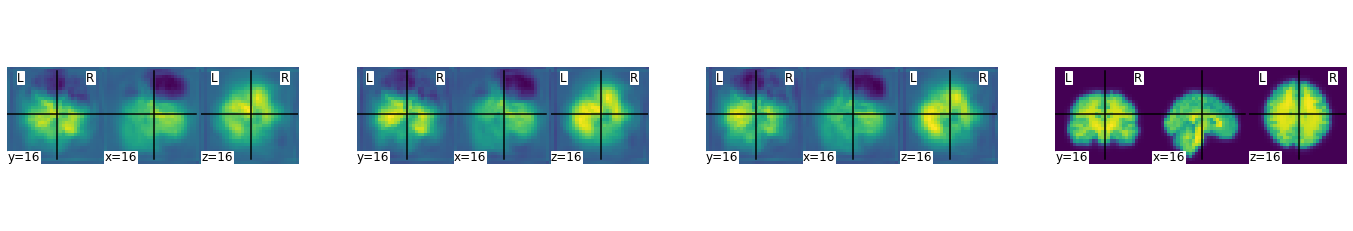

In [ ]:
G.eval() # eval mode for generating samples
samples_z = G(fixed_z)
G.train() # back to train mode


f = plt.figure(figsize=(24, 4))
for i in range(1, 4):
  ax = plt.subplot(1, 4, i)
  plot_scan(samples_z[i-1][0].detach().cpu(), axes=ax)
ax = plt.subplot(1, 4, 4)
plot_scan(real_images[0][0].detach().cpu(), axes=ax)
plt.show()


In [ ]:


torch.save(G.state_dict(), 'MyDrive/stylegan_generator_weights.pkl')
torch.save(D.state_dict(), 'MyDrive/stylegan_discriminator_weights.pkl')